In [1]:
import sys

# Uncommon libraries
# !{sys.executable} -m pip install MFDFA
# !{sys.executable} -m pip install git+https://github.com/manu-mannattil/nolitsa.git

In [10]:
# Convenience functions
def AddSysPath(new_path):
    """ AddSysPath(new_path): adds a directory to Python's sys.path

    Does not add the directory if it does not exist or if it's already on
    sys.path. Returns 1 if OK, -1 if new_path does not exist, 0 if it was
    already on sys.path.
    """
    import sys, os

    # Avoid adding nonexistent paths
    if not os.path.exists(new_path): return -1

    # Standardize the path. Windows is case-insensitive, so lowercase
    # for definiteness.
    new_path = os.path.abspath(new_path)
    if sys.platform == 'win32':
        new_path = new_path.lower(  )

    # Check against all currently available paths
    for x in sys.path:
        x = os.path.abspath(x)
        if sys.platform == 'win32':
            x = x.lower(  )
        if new_path in (x, x + os.sep):
            return 0
    sys.path.append(new_path)
    return 1



def ftostr(f, dp=4):
    fmt = "{0:."+str(dp)+"f}"
    print(fmt)
    return fmt.format(f)


In [26]:
# SETUP
%load_ext autoreload
%autoreload 2

SCALECOUNT = 32

# LOCAL .py files

import sys
# scripts for analysis and plotting
AddSysPath("./")

from processing import *
from checking import *
# implementation of (monofractal) DFA for pre-analysis
# Legacy - it would be neater to update code to use Rydin library as for MDFA
from dokatodfa import *


# we will on occasion get underflows in the mfdfa. It is difficult to avoid this and the effect on resutls is minimal
np.seterr(all='raise')
np.seterr(under='ignore')
np.seterr(divide='warn')

idx = pd.IndexSlice


logfile = "./eye_gaze_forestry_tuning.txt"

#  Set this directory to the location of your data for analysis
#  we provide prepared data in the form of pkl files
dataDir = "./"

#  Number of steps between Q exponents. 
# Generally examples in the literature use increments of 0.25 or 0.5 (e.g. 4 or 2)
QSTEP = 4

# Minimum scale of analysis
MINSCALE = 8

# How many surrogates to use (higher is much slower but more stable)
# Min ~30 to approximate a normal distribution
surrCount=50


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Functions for multi-core processing 

large datasets and tuning can be slow

In [5]:

import multiprocessing as mp
import psutil 
from functools import partial

def mfdfa_multiprocess(data, scales, qs, order=1, surrogateCount=100,  sig = 'signal', window=64, maxThreads=32):
    allData = []
    # create version of function with unchanging params set to constants
    multiMFDFA = partial(MFDFA_Process2, 
                         scales=scales, 
                         qs=qs, 
                         order=order, 
                         surrogateCount=surrogateCount, 
                         sig = sig,
                         window = window,                         
                         returnOnlyHs = False
                        )
    
    if __name__ ==  '__main__': 
        # 1. Define no of processes coreCount     
        coreCount = psutil.cpu_count(logical=False)     
        if coreCount > maxThreads:
            coreCount = maxThreads
        # 2. split data into p dataframes   
        trials = data.index.get_level_values(0).unique()
        items = len(trials)
        trialChunks = np.array_split(trials, items)     
        dfChunks =[]
        for i, c in enumerate(trialChunks):
            dfChunks.append(data.loc[idx[c], :])
        # spawn processes and process dataframes 
        p=mp.Pool(processes = coreCount)
        results = p.map(multiMFDFA, dfChunks)
        p.close()
        p.join()

        holders = []
        taus = []
        diagnostics = []
        r2s = []
        coeffs = []
        print("data processed")
        for r in results:
            holders.append(r[0])
            taus.append(r[1])
            diagnostics.append(r[2])
        return pd.concat(holders), pd.concat(taus), pd.concat(diagnostics)
        
        



def surrogates_multiprocess(data, surrogateCount, sig, maxThreads=32):
    allData = []
    multiSurr = partial(generateSurrogates, 
                         surrogateCount=surrogateCount, 
                         sig=sig
                        )      
    if __name__ ==  '__main__': 
        # 1. Define no of processes coreCount     
        coreCount = psutil.cpu_count(logical=False)     
        if coreCount > maxThreads:
            coreCount = maxThreads
        # 2. split data into p dataframes   
        trials = data.index.get_level_values(0).unique()
        items = len(trials)
        trialChunks = np.array_split(trials, items)     
        dfChunks =[]
        for i, c in enumerate(trialChunks):
            dfChunks.append(data.loc[idx[c], :])
        # spawn processes and process dataframes 
        p=mp.Pool(processes = coreCount)
        surr = p.map(multiSurr, dfChunks)
        p.close()
        p.join()
        return pd.concat(surr)
        # rejoin data    

print(psutil.cpu_count(logical=False))

4


# Data prep - load, and get our data into the right format

In [57]:
print(dataDir + "/gazes30fps.pkl")

conditions = ["e","n"]

df = pd.read_pickle(dataDir + "/gazes30fps.pkl")
conditions = ["e", "n"]
df.head(10)

df = df.reset_index(drop=False)

df["trialID"] = df["trialID"] + "_1"

df = df.set_index(["trialID", "sampleNo"])

df

.//gazes30fps.pkl


gazeX   gazeY participant skill    boom condition  \
trialID   sampleNo                                                       
P11-0_1_1 1         140.36  352.29          11     n  normal         n   
          2         137.77  365.58          11     n  normal         n   
          3         131.59  378.19          11     n  normal         n   
          4         119.80  383.73          11     n  normal         n   
          5         112.47  382.00          11     n  normal         n   
...                    ...     ...         ...   ...     ...       ...   
P9-2_1_1  2133      598.33  361.26           9     n  normal         n   
          2134      594.65  357.98           9     n  normal         n   
          2135      594.46  356.23           9     n  normal         n   
          2136      596.10  356.26           9     n  normal         n   
          2137      597.92  359.03           9     n  normal         n   

                   session        time  segment_id pid  originalsampleNo  \
trialID   sampleNo                                                         
P11-0_1_1 1          P11_1   40.100000           0                  1203   
          2          P11_1   40.133333           0                  1204   
          3          P11_1   40.166667           0                  1205   
          4          P11_1   40.200000           0                  1206   
          5          P11_1   40.233333           0                  1207   
...                    ...         ...         ...  ..               ...   
P9-2_1_1  2133        P9_1  236.400000           2                  7092   
          2134        P9_1  236.433333           2                  7093   
          2135        P9_1  236.466667           2                  7094   
          2136        P9_1  236.500000           2                  7095   
          2137        P9_1  236.533333           2                  7096   

                       dx     dy        euc     signal  sample_copy  
trialID   sampleNo                                                   
P11-0_1_1 1           NaN    NaN        NaN        NaN            1  
          2         -2.59  13.29   3.662813   3.662813            2  
          3         -6.18  12.61   8.739840   8.739840            3  
          4        -11.79   5.54  16.673578  16.673578            4  
          5         -7.33  -1.73  10.366185  10.366185            5  
...                   ...    ...        ...        ...          ...  
P9-2_1_1  2133      -2.05  -3.78   2.899138   2.899138         2133  
          2134      -3.68  -3.28   5.204306   5.204306         2134  
          2135      -0.19  -1.75   0.268701   0.268701         2135  
          2136       1.64   0.03   2.319310   2.319310         2136  
          2137       1.82   2.77   2.573869   2.573869         2137  

[50529 rows x 16 columns]

# Define datasets for analyses

In [7]:
# Exclude session with poor data quality
df = df[df["session"]!="P5_1"] 

# Look at sample lengths - recommended to stay at c 1000 or higher for good fits
# 3 trials gave us 940 minimum, which resulted in good fits
sampleLengths = pd.DataFrame(df.groupby(["trialID"])["sample_copy"].max())
sampleLengths

,sample_copy
trialID,
P1-0_1,1010
P1-1_1,1072
P1-2_1,1106
P11-0_1,1560
P11-1_1,1261
P11-2_1,1380
P12-0_1,1140
P12-1_1,1300
P12-2_1,1140


In [8]:
# get rid of na values in the signal (signal was diff'd to generate a euclidean distance series)

untrimmedData = df.loc[(df["signal"].notna())]

## Pre-Analysis

In [13]:
# Trim datasets to same length (differences in length can result in differences in multifractality)

preparedData, sampleLen = makeUniformLength(untrimmedData) 
print("sample Length:", sampleLen)

# do we need to integrate data?
scalingExponents = runDFA(preparedData)

print("if Hurst exponent is below 0, integrate and recheck")




sample Length: 940
mean: 0.9372730694756074 std: 0.1208452352710525 min/max: 0.6505214953734862 / 1.2509741548267188
mean Hurst exponent: -0.0627269305243926
integrate input before WTMM
if Hurst exponent is below 0, integrate and recheck


if below 0, integrate and recheck

In [19]:
preparedData = integrateSignal(preparedData)
integratedScaling = runDFA(preparedData, "signalIntegral")

# set to "signal" if integration was not required, "signalIntegral", if it was
sig = 'signalIntegral'

mean: 1.7403940323745923 std: 0.12458340794418825 min/max: 1.478896166076739 / 2.098615724468681
mean Hurst exponent: 0.7403940323745923
no need to integrate input before WTMM


## MDFA Tuning

In [23]:
# Convenience function to test a range of parameters


def runConfirmation(data, qMin, qMax, description, logfile, sig, scales, order = 1, qstep=QSTEP, window=64):
    qs = np.arange(qMin,qMax+0.0001,1.0/qstep)
    holders, taus, diagnostics = mfdfa_multiprocess(data, scales, qs, surrogateCount=surrCount, sig = sig,order = order, window=window)

    holders['participant'] = holders['key'].str.split(pat = "_").str[0]
    holders['session'] = holders['key'].str.split(pat = "_").str[1]
    w ,h = analyseHolderSpectra(holders)
    results, summary = summariseResults(w)
    print(description, "Qs:", qMin, qMax)
    print(tabulate(summary, headers='keys', tablefmt='psql'))   
    
    
    print("goodness of fit for the Hurst exponents")
    diagnostics["scale"] = maxScale   
    r2 = pd.DataFrame(diagnostics["r2"]) 
    r2 = r2.explode('r2')
    r2["r2"]=r2["r2"].astype('float64')
    print("min", r2.min().values[0], "mean", r2.mean().values[0], "SD", r2.std().values[0])        

    return h, w, results, summary, diagnostics



In [84]:

preparedData = surrogates_multiprocess(preparedData, surrCount, sig)

### Save results of selection and surrogate generation 
IAFFT is a random process, so to document our results, we reload data here from our own surrogate generation

Comment, or do not run the cell below to try with newly generated surrogates (which may result in slightly different results - though we use 50 surrogates to ensure results are be reasonably stable.)


In [16]:
# preparedData.to_pickle("./selected_data_with_surrogates.pkl")

preparedData = pd.read_pickle("./selected_data_with_surrogates.pkl")

# SELECT MAX SCALE

Using parameters found to be valid in previous work on movement. If relevant parameters are not known, scale selection can be revisited after order and q selection

In [28]:
order = 3
qMin = -3.0
qMax = 3.0
qs = np.arange(qMin,qMax+0.0001,1.0/QSTEP)

scaleList = [32,64,128]

lf = "./fatigue_scales.txt"

summaries_scale=[]
diagnostics_scale =[]
tstats = []
r2s=[]
for maxScale in scaleList:
    scales = generateScaleList(maxScale*4, minscale = MINSCALE) 
    print("maxScale ", str(maxScale))
    ret =runConfirmation(preparedData,qMin, qMax, str(maxScale), logfile = lf, sig=sig, scales = scales, order=order)
    summary = ret[3]
    diag=ret[4]
    summary["qmin"] = qMin
    summary["qmax"] = qMax    
    summary["description"] = str(maxScale)    
    summary["sig"] = sig        
    summary["order"] = order   
    summary["length"] = sampleLen      
    summaries_scale.append(summary)
    diag["qmin"] = qMin
    diag["qmax"] = qMax    
    diag["order"] = order   
    diagnostics_scale.append(diag)
    
    print("goodness of fit for the Hurst exponents")
    r2 = pd.DataFrame(diag["r2"]) 
    r2 = r2.explode('r2')
    r2["r2"]=r2["r2"].astype('float64')
    r2s.append(r2)
    print("min", r2.min().values[0], "mean", r2.mean().values[0], "SD", r2.std().values[0])      
    tstats.append(summary.loc[idx["Overall"],"t-stat"])
    
summaries_scale = pd.concat(summaries_scale)
diagnostics_scale = pd.concat(diagnostics_scale)


maxScale  32
data processed
32 Qs: -3.0 3.0
+---------+---------+----------+----------+----------------------+
|         |    mean |      std |   t-stat |   confidenceInterval |
|---------+---------+----------+----------+----------------------|
| n       | 1.19219 | 0.385629 |  58.4785 |                    1 |
| e       | 1.48832 | 0.334862 |  51.7655 |                    1 |
| Overall | 1.31558 | 0.389554 | 110.244  |                    1 |
+---------+---------+----------+----------+----------------------+
goodness of fit for the Hurst exponents
min 0.9980327129358934 mean 0.9996487473689569 SD 0.00030355431175815004
goodness of fit for the Hurst exponents
min 0.9980327129358934 mean 0.9996487473689569 SD 0.00030355431175815004
maxScale  64
data processed
64 Qs: -3.0 3.0
+---------+---------+----------+----------+----------------------+
|         |    mean |      std |   t-stat |   confidenceInterval |
|---------+---------+----------+----------+----------------------|
| n       | 1.05

Select scale by finding the knee of the t-statistic against scale if a knee is present (and enough scales are tested)

Here there are relatively few options below c 1000 samples (max scale should be < 1/4 sample length to ensure good fitting of statistics), so finding the knee is redundant, but we include as an example

In this case, the peak summed t-stat is used to select scale of analysis


C:\Users\dan\anaconda3\lib\site-packages\kneed\knee_locator.py:304: UserWarning: No knee/elbow found
  warnings.warn("No knee/elbow found")


TypeError: type NoneType doesn't define __round__ method

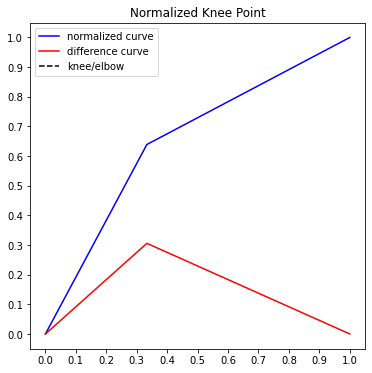

In [33]:
from kneed import DataGenerator, KneeLocator

kneedle = KneeLocator(scaleList, tstats, S=1, curve="concave", direction="increasing")
kneedle.plot_knee_normalized()
print(round(kneedle.knee, 3))


## Order and Qs

In [ ]:

# Set max scale based on the results above
maxScale = 128 

paramsToTest = [    
                (-2 ,  2, "symmetrical"),          
                (-3 ,  3, "symmetrical"),    
                (-4 ,  4, "symmetrical"), 
                (-5 ,  5, "symmetrical"),      # ihlen - sufficient for most biological datasets
                (-2 ,  3, "asymmetrical"),        
                (-2 ,  4, "asymmetrical"),    
                (-2 ,  5, "asymmetrical"),   
                 (-3 ,  4, "asymmetrical"),      
                 (-3 ,  5, "asymmetrical"),  
                ]


lf = "./lying_issues_best_params.txt"

summaries=[]
diagnostics =[]
for order in [1,2,3,4,5]: 
    scales = generateScaleList(maxScale*4, minscale= MINSCALE ) 
    print("order ", str(order))
    for p in paramsToTest:
        ret =runConfirmation(preparedData,p[0], p[1], p[2], logfile = lf, sig=sig, scales = scales, order=order)
        summary = ret[3]
        diag=ret[4]
        summary["qmin"] = p[0]
        summary["qmax"] = p[1]    
        summary["description"] = p[2]     
        summary["sig"] = sig        
        summary["order"] = order   
        summary["length"] = sampleLen      
        summaries.append(summary)
        diag["qmin"] = p[0]
        diag["qmax"] = p[1]    
        diag["order"] = order   
        diagnostics.append(diag)

summaries = pd.concat(summaries)
diagnostics = pd.concat(diagnostics)

In [ ]:
# Summarise R values (fit of the fluctuation functions) and view the top scoring results with valid fits

q_and_order_results = summaries.loc[(idx['Overall'])][["t-stat","order", "qmin","qmax"]]

q_and_order_results.reset_index(inplace=True, drop=True)
q_and_order_results["r_min"] = 0.0
q_and_order_results["r_mean"] = 0.0

for i, r in q_and_order_results.iterrows():
    rs = np.hstack(diagnostics[(diagnostics['qmin']==r.qmin)& (diagnostics['qmax']==r.qmax) & (diagnostics['order']==r.order)]["r2"].values)
    q_and_order_results.iat[i,7] = rs.min()
    q_and_order_results.iat[i,8] = rs.mean()
    


q_and_order_results[(q_and_order_results["r_min"]>=0.99)].sort_values('t-stat',ascending=False).head(10)




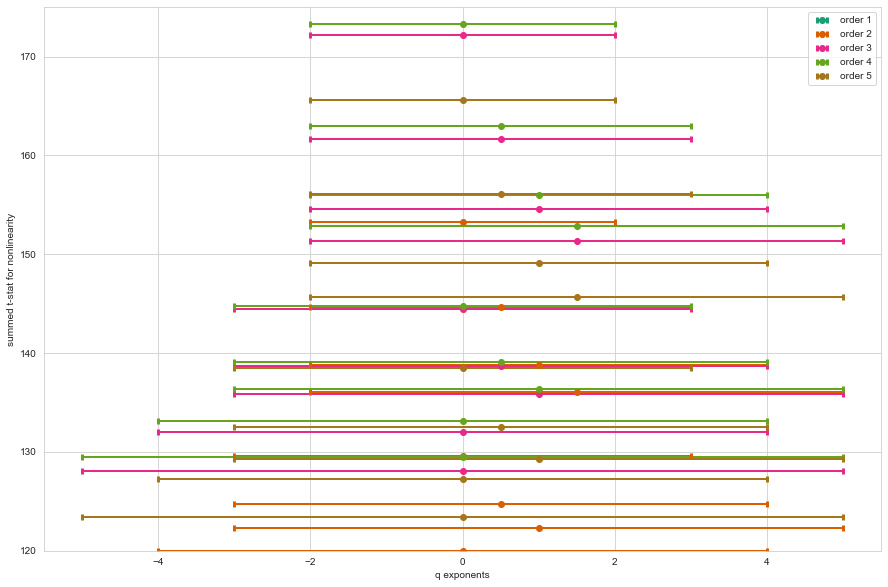

In [99]:
# Visualise how orders of analysis and q values relate to fit

linewidth = 2
capthick = 3
capsize = 3

validR = q_and_order_results[(q_and_order_results["r_min"]>= 0.990)]

# Can plot these separately if of interest
invalidR = q_and_order_results[(q_and_order_results["r_min"]< 0.990)]

for i in [1,2,3,4,5]:
    color = mpl.cm.Dark2((i-1)/5)
    
    df = validR[validR["order"]==i]
    width = (df.qmax.values - df.qmin.values)/2
    midpoint = ((df.qmax.values - df.qmin.values) / 2) + df.qmin.values
    tstat = df.t-stat.values    
    eb2 = plt.errorbar(midpoint, tstat, xerr=width, fmt='o', label="order "+ str(i), 
                       color = color, linewidth = linewidth, capsize=capsize, capthick=capthick, )

plt.rcParams["figure.figsize"] = (15,10)

plt.ylim(120,175)
plt.legend()
plt.xlabel('q exponents')
plt.ylabel('summed t-stat for nonlinearity')
plt.show()

## Check results for our selected parameters

In [35]:

# Parameters selected from surgeon data for now - tune later
sig = 'signalIntegral'
order = 4
qMin = -2.0
qMax = 2.0
maxScale = 128


# Other params
surrCount = 50
qs = np.arange(qMin,qMax+0.0001,1.0/QSTEP)
scales = generateScaleList(maxScale*4, minscale = MINSCALE)   
print(scales)

# Run analysis
holders ,taos, diagnostics = mfdfa_multiprocess(preparedData, scales, qs, order = order, sig = sig, surrogateCount = surrCount)

holders['participant'] = holders['key'].str.split(pat = "_").str[0]
holders['session'] = holders['key'].str.split(pat = "_").str[1]

w ,h = analyseHolderSpectra(holders)

# Get and print results of surrogate analysis
results, summary = summariseResults(w)



[  8   9  10  11  12  13  14  16  17  19  21  23  25  27  30  33  36  40
  43  47  52  57  62  68  74  81  89  97 107 117 128]
data processed


### Sense check the results - check for normality, variance etc.

C:\Users\dan\AppData\Roaming\Python\Python38\site-packages\pandas\core\frame.py:4295: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


Order:  4 Qs: -2.0 2.0
+---------+----------+----------+----------+----------------------+
|         |     mean |      std |   t-stat |   confidenceInterval |
|---------+----------+----------+----------+----------------------|
| n       | 0.958035 | 0.242999 |   96.844 |                    1 |
| e       | 1.1431   | 0.171482 |   79.112 |                    1 |
| Overall | 1.03515  | 0.232522 |  175.956 |                    1 |
+---------+----------+----------+----------+----------------------+
------------ Condition Plots -----------------


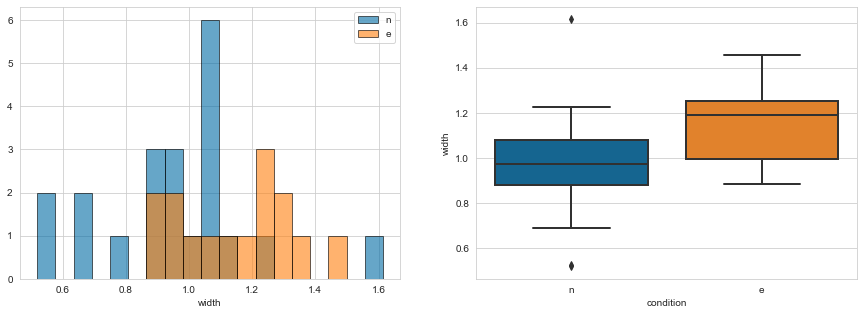

+-----+--------+--------+--------+--------+--------+---------+------------+--------------+------------------+
|     |    min |    max |    iqr |   mean |    std |   count | isNormal   |   shapiroVal |   Outliers(3IQR) |
|-----+--------+--------+--------+--------+--------+---------+------------+--------------+------------------|
| n   | 0.5194 | 1.6141 | 0.1975 | 0.9580 | 0.2430 |      21 | True       |       0.1153 |                0 |
| e   | 0.8857 | 1.4548 | 0.2589 | 1.1431 | 0.1715 |      15 | True       |       0.5457 |                0 |
| all | 0.5194 | 1.6141 | 0.2813 | 1.0351 | 0.2325 |      36 | True       |       0.6261 |                0 |
+-----+--------+--------+--------+--------+--------+---------+------------+--------------+------------------+
Levene test result: t:  0.4049 p:  0.5288 - populations  are of equal variance
------------ Condition Plots -----------------


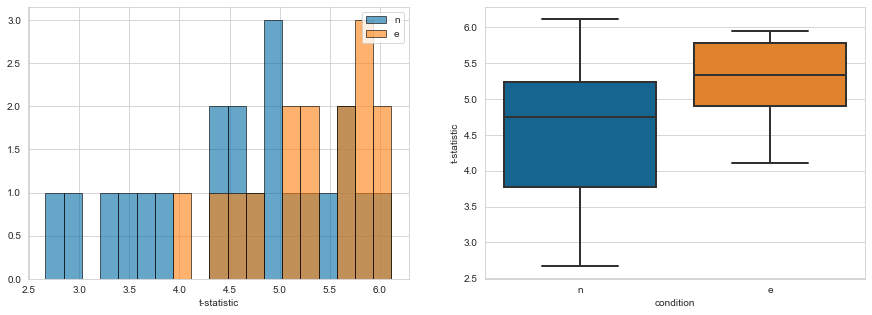

+-----+--------+--------+--------+--------+--------+---------+------------+--------------+------------------+
|     |    min |    max |    iqr |   mean |    std |   count | isNormal   |   shapiroVal |   Outliers(3IQR) |
|-----+--------+--------+--------+--------+--------+---------+------------+--------------+------------------|
| n   | 2.6645 | 6.1137 | 1.4671 | 4.6116 | 0.9672 |      21 | True       |       0.4862 |                0 |
| e   | 4.1042 | 5.9469 | 0.8880 | 5.2741 | 0.6192 |      15 | True       |       0.0926 |                0 |
| all | 2.6645 | 6.1137 | 1.2510 | 4.8877 | 0.8931 |      36 | False      |       0.0345 |                0 |
+-----+--------+--------+--------+--------+--------+---------+------------+--------------+------------------+
Levene test result: t:  2.1419 p:  0.1525 - populations  are of equal variance


In [37]:
results.rename(columns={'surrZindex': 't-statistic'}, inplace=True)

print("Order: ", order, "Qs:", qMin, qMax)
print(tabulate(summary, headers='keys', tablefmt='psql'))


__ = preAnalysisInspection(inputTable=results, 
                           conditionIdx="condition", 
                           participantIdx="participant", 
                           dataCol="width", 
                           within=False
                          )



__ = preAnalysisInspection(inputTable=results, 
                           conditionIdx="condition", 
                           participantIdx="participant", 
                           dataCol="t-statistic", 
                           within=False
                          )

## Validating the fits

Beyond the r^2 value, do fits have any other problems (e.g. nonlinearity at the lowest scales)

Again, we load from pkl files to allow shortcutting, but you can skip this cell to continue with your own analysis

In [40]:

# holders.to_pickle("mf_holder.pkl")
# summary.to_pickle("mf_summary.pkl")
# results.to_pickle("mf_results.pkl")
# h.to_pickle("mf_h.pkl")
# taos.to_pickle("mf_taos.pkl")
# diagnostics.to_pickle("mf_diagnostics.pkl")


holders = pd.read_pickle("./mf_holder.pkl")
summary = pd.read_pickle("./mf_summary.pkl")
results = pd.read_pickle("./mf_results.pkl")
h = pd.read_pickle("./mf_h.pkl")
taos = pd.read_pickle("./mf_taos.pkl")
diagnostics = pd.read_pickle("./mf_diagnostics.pkl")


In [42]:
def plotFsLogScaleAxes(fs, scales, textSize = 20, tickScale = 0.6, ax = None):
    import matplotlib.ticker as mticker
    
    logLags = np.log(scales)
    logFs = np.log(fs)
    if ax is None:
        fig = plt.figure(figsize=(12,10)) 
        ax = fig.add_subplot(111)

    
    ax.set_prop_cycle(None)
    ax.plot(scales,fs, linestyle="", marker ='o', markersize=2)

    myFitting = np.polyfit(logLags, logFs,1, full=True)
    coeff = myFitting[0]
    SSE = myFitting[1]

    diff = logFs - np.mean(logFs)
    square_diff = diff ** 2
    SST = square_diff.sum()
    R2 = 1 - SSE/SST 
#     print("R2:", R2)
#     print("lags:", scales)
    ax.set_prop_cycle(None)
    for i, f in enumerate(coeff[0]):
        linear_model_fn=np.poly1d(coeff[:,i])
        ax.plot(scales,np.exp(linear_model_fn(logLags)), linewidth = 1, alpha=0.5)
        
    ax.semilogx()
    ax.semilogy(basey=2)
    ax.grid(True)
    ax.set_xlabel("scale of analysis")
    ax.set_ylabel("fluctuation function (F(s))")
    ax.xaxis.set_minor_formatter(mticker.ScalarFormatter())
    ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
    ax.yaxis.set_minor_formatter(mticker.ScalarFormatter())
    ax.yaxis.set_major_formatter(mticker.ScalarFormatter())
    ax.tick_params(axis='x', which='major', labelsize=textSize*tickScale, pad=textSize*tickScale)
    ax.tick_params(axis='y', which='major', labelsize=textSize*tickScale, pad=textSize*tickScale*0.1)

    ax.tick_params(axis='both', which='minor', labelsize=textSize*tickScale)

    ax.xaxis.label.set_size(textSize)
    ax.yaxis.label.set_size(textSize)
    ax.yaxis.labelpad = -2


In [47]:
# prepare diagnostics for viewing and plotting

diagnostics.reset_index(inplace=True, drop=True)
diagnostics["minR"] = 0.0
diagnostics["meanR"] = 0.0

for i, d in diagnostics.iterrows():
    diagnostics.iat[i,-1] =(d["r2"].min())
    diagnostics.iat[i,-2] =(d["r2"].mean())

In [48]:
diagnostics.sort_values("meanR", ascending= False)

,trialID,condition,fq,r2,coeff,minR,meanR
6,P13-0_1,e,"[[0.3134405655059787, 0.3339636296909839, 0.35...","[0.999681143262111, 0.9997036469000219, 0.9997...","[[2.3975532526788994, 2.385949876071143, 2.373...",0.999696,0.999660
33,P9-0_1,n,"[[0.5720629061156535, 0.6199712958534244, 0.67...","[0.9996087070292006, 0.9996585482336608, 0.999...","[[2.2782821506832147, 2.266397063168087, 2.250...",0.999790,0.999609
16,P1-1_1,n,"[[0.34850418658258053, 0.3803848024875386, 0.4...","[0.9995841094206083, 0.999619811051941, 0.9996...","[[2.345386994938652, 2.3413159428889667, 2.337...",0.999674,0.999584
7,P13-1_1,e,"[[0.29140061354433144, 0.30881474132228476, 0....","[0.999578277109809, 0.999629472922688, 0.99967...","[[2.4361653453699788, 2.444523521666345, 2.453...",0.999722,0.999578
34,P9-1_1,n,"[[0.3516978745039852, 0.3985270305491482, 0.45...","[0.9995500728706006, 0.9995982642147421, 0.999...","[[2.196089192292541, 2.1878039557731537, 2.179...",0.999732,0.999550
23,P4-2_1,n,"[[0.6629225954938347, 0.7335770308443283, 0.82...","[0.9994687871310676, 0.9995432471721505, 0.999...","[[2.392430082184089, 2.381809382338863, 2.3719...",0.999695,0.999469
0,P11-0_1,n,"[[0.3508924784325084, 0.3784049757876681, 0.41...","[0.9996088561851608, 0.9996414805212146, 0.999...","[[2.144790098758488, 2.140404683042515, 2.1363...",0.999568,0.999437
17,P1-2_1,n,"[[0.25525275189629304, 0.2908598236157571, 0.3...","[0.9993945606650805, 0.9995072796279343, 0.999...","[[2.3046676018272607, 2.286273460105244, 2.270...",0.999701,0.999395
28,P7-1_1,e,"[[0.41627288898713183, 0.45473947947550275, 0....","[0.9993825660703283, 0.9994056517095706, 0.999...","[[2.259653870874142, 2.238556676333062, 2.2140...",0.999540,0.999383
35,P9-2_1,n,"[[0.28877119592395545, 0.327205386747085, 0.37...","[0.999368935655344, 0.9994698373237302, 0.9995...","[[2.1188272683873253, 2.1014896655268704, 2.08...",0.999723,0.999369


### Plot functions for different trials to sense check

Our table shows that all fits are at a minimum > 0.999 which gives high level of confidence in validity of analysis.

Further sense checks can be completed by checking the analysis pipeline.

Change "row" to check different trials

We look in particular for linearity in the fluctuation function (in particularity at lower scales where we may see non linearity as the f(s) values drop due to overfitting of the detrending line. This is likely to result from the order of the detrending function being too order relative to the smallest scale of analysis. Increasing scale or decreasing order can fix the issue 


P6-0_1


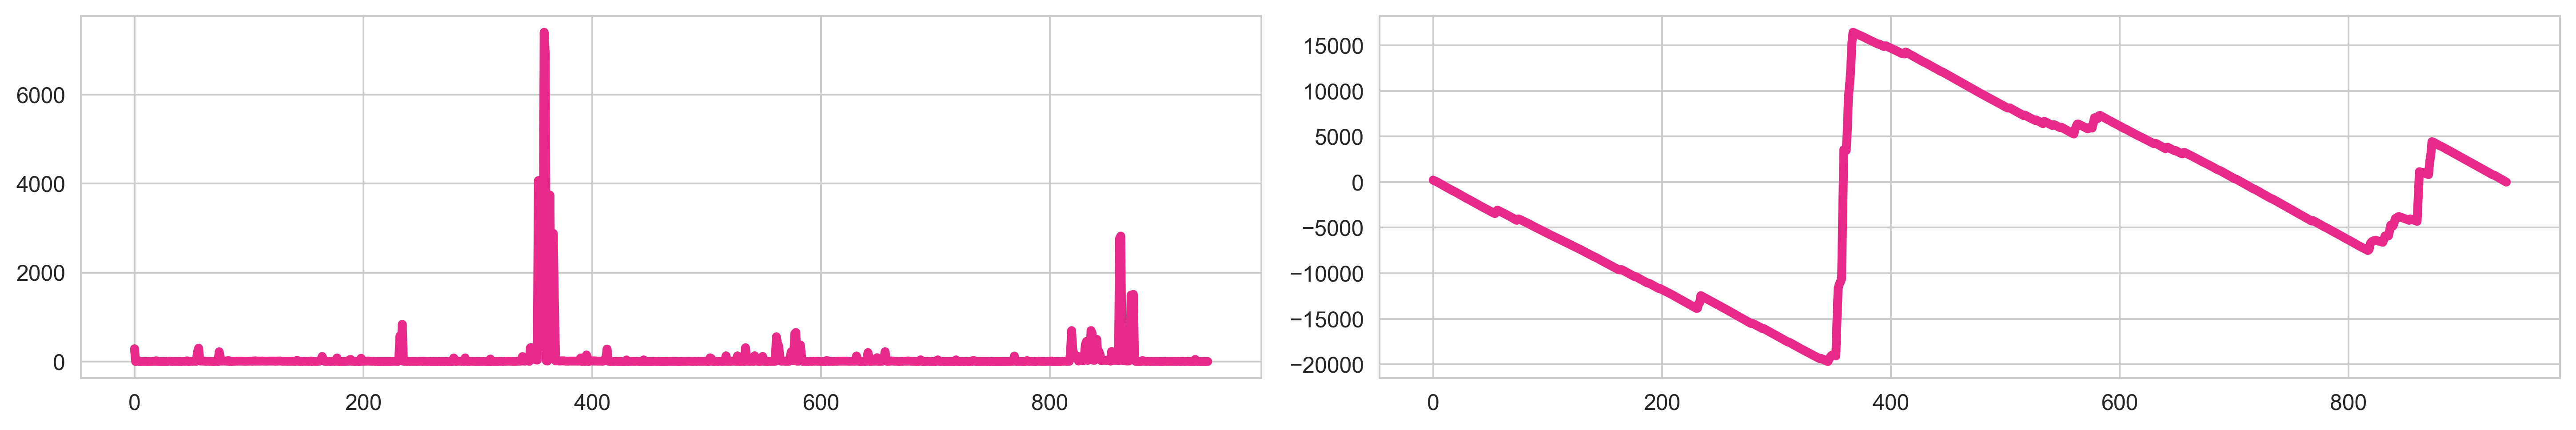

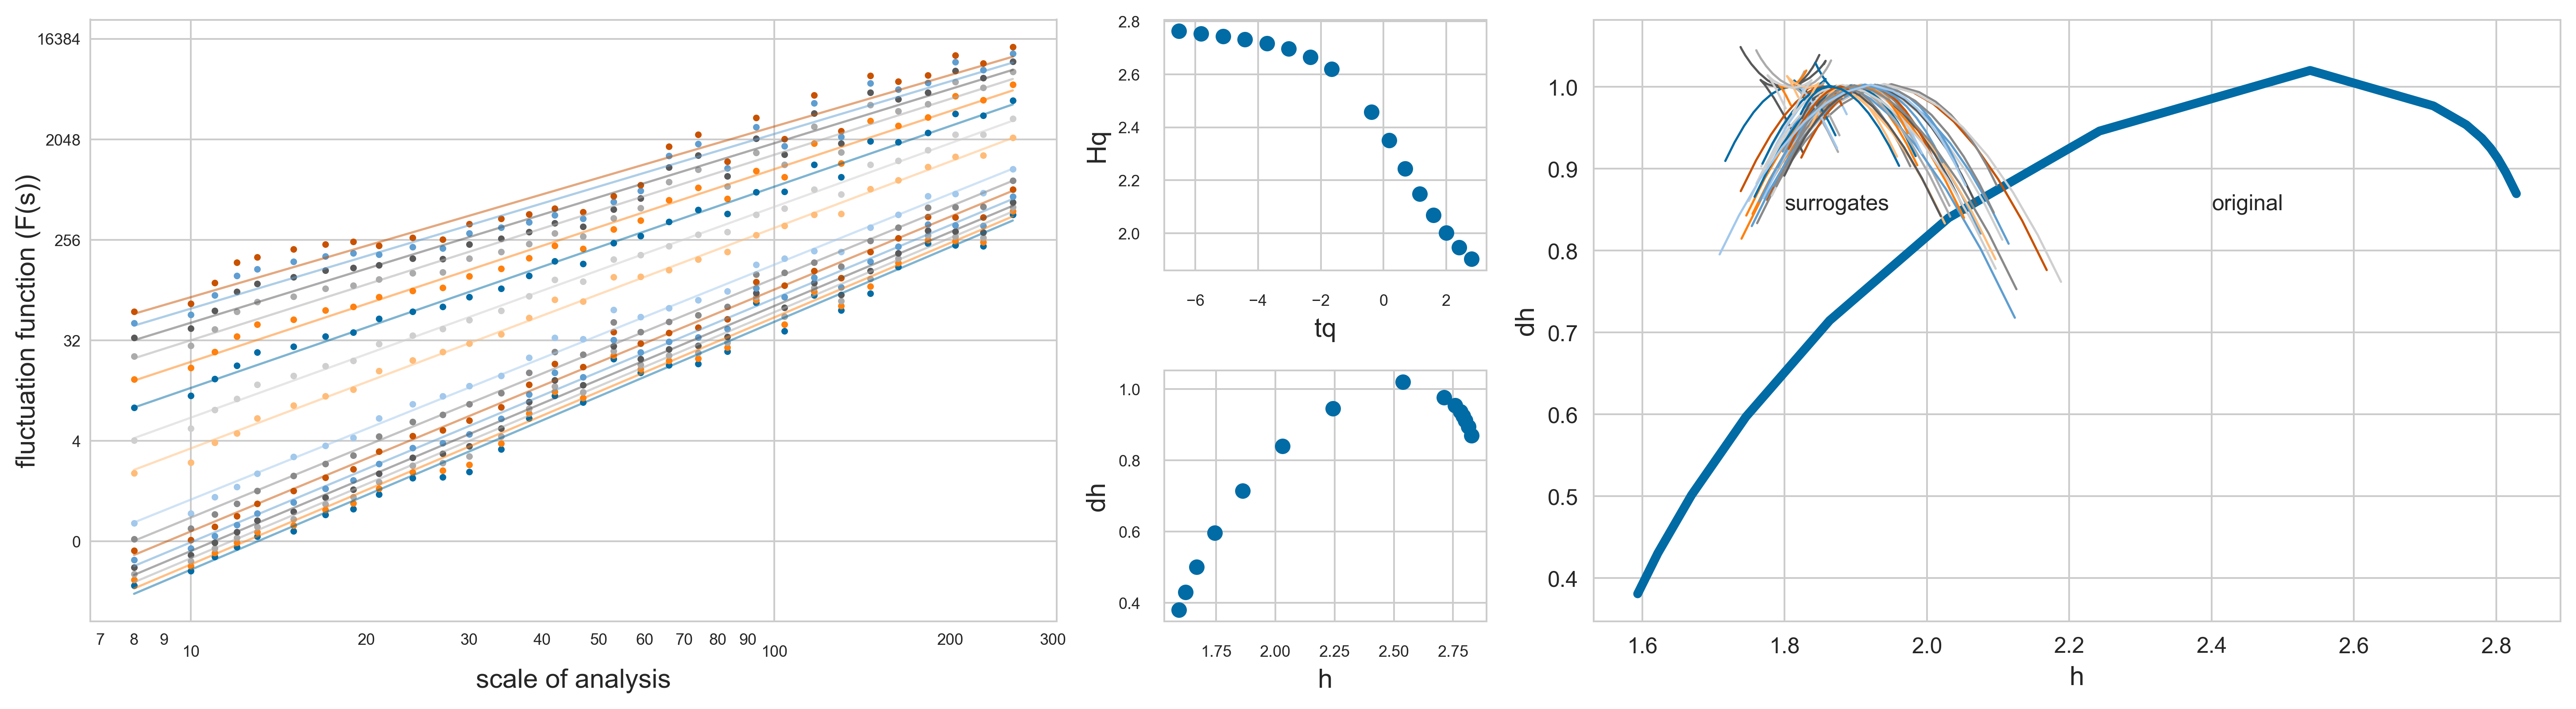

In [46]:

row=24


textSize = 20
tickScale = 0.6

truncate = 0
count_of_samples = 5
participant = diagnostics.iloc[row]["trialID"]
print(participant)
scales = generateScaleList(256*4, minscale = MINSCALE)[:]


# Plot signals
fig1 = plt.figure(num=None, figsize=(20, 3), dpi=360)
ax1 = plt.subplot2grid((1, 2), (0, 0))
ax2 = plt.subplot2grid((1, 2), (0, 1))

signal = preparedData.loc[idx[participant,:],"signal"].values
ax1.plot(signal, linewidth = 4, color = mpl.cm.Dark2(2/5))

signal = preparedData.loc[idx[participant,:],"signalIntegral"].values
ax2.plot(signal, linewidth = 4, color = mpl.cm.Dark2(2/5))
# ax1.set_aspect('equal')
# ax2.set_aspect('equal')
fig1.subplots_adjust(wspace=0.1, hspace=0)
fig1.savefig("./signals.svg", bbox_inches='tight', format='svg')

plt.show()

textSize = 12
tickScale = 0.6
size = (20, 5)
r = 2
c = 12
midPlotWidth = 2
otherWidths = (c -midPlotWidth) // 2

fig2 = plt.figure(num=None, figsize=size, dpi=360)
axfluct = plt.subplot2grid((r, c), (0, 0), colspan=otherWidths, rowspan=2)
axtau = plt.subplot2grid((r, c), (0, otherWidths), colspan=midPlotWidth, rowspan=1)
axholder = plt.subplot2grid((r, c), (1, otherWidths), colspan=midPlotWidth, rowspan=1)
axsurr = plt.subplot2grid((r, c), (0, otherWidths+midPlotWidth), colspan=otherWidths, rowspan=2)


# Plot tau and holder plots
df = taos[taos["participant"]==participant.split("_")[0]]

axtau.scatter(df.tq, df.Hq)
axtau.set_xlabel("tq")
axtau.set_ylabel("Hq")
axtau.tick_params(axis='both', which='major', labelsize=textSize*tickScale, pad=textSize*tickScale)
axtau.tick_params(axis='both', which='minor', labelsize=textSize*tickScale)
axtau.xaxis.label.set_size(textSize)
axtau.yaxis.label.set_size(textSize)

df = holders[(holders["participant"]==participant.split("_")[0]) & (holders["type"]=="original")]
axholder.scatter(df.h, df.dh)
axholder.set_xlabel("h")
axholder.set_ylabel("dh")
axholder.tick_params(axis='both', which='major', labelsize=textSize*tickScale, pad=textSize*tickScale)
axholder.tick_params(axis='both', which='minor', labelsize=textSize*tickScale)
axholder.xaxis.label.set_size(textSize)
axholder.yaxis.label.set_size(textSize)


plotFsLogScaleAxes(diagnostics.iat[row,2], scales[:], textSize = textSize, tickScale = 0.6, ax = axfluct)


df1 = holders[(holders["participant"]==participant.split("_")[0])]
items = df1["type"].unique()

for item in items:
    df = df1[df1["type"]==item]
    if item == "original":
        linewidth = 4
        
    else:
        linewidth = 1
    axsurr.plot(df.h, df.dh, linewidth = linewidth)   
axsurr.set_xlabel("h")
axsurr.set_ylabel("dh")
axsurr.text(2.4,0.85,'original')
axsurr.text(1.8,0.85,'surrogates')
axsurr.xaxis.label.set_size(textSize)
axsurr.yaxis.label.set_size(textSize)

fig2.subplots_adjust(wspace=1, hspace=0.4)
plt.show()

fig2.savefig("./mf_plots.svg", bbox_inches='tight', format='svg')

## Hypothesis tests

Assuming all results above are valid we can proceed to hypothesis tests

In [49]:
widths = pd.DataFrame(h.groupby(['key', "type", "condition", "participant", "session"]).apply(lambda x: x['h'].max() - x['h'].min()), columns=['width'])
widths = widths.reset_index(level=[1])
widths.loc[widths["type"]!="original","type"] = "surrogate"
widths.set_index(['type'], inplace=True, append=True)

c1 = widths.loc[idx[:,conditions[0], :,:,:],:]
c2 = widths.loc[idx[:,conditions[1], :,:,:],:]



print()
print("BETWEEN PARTICIPANTS")
averaged = results.groupby(["participant", "condition"]).mean()
c0 = results.loc[idx[:, conditions[0]], "width"].values
c1 = results.loc[idx[:, conditions[1]], "width"].values
T,p = stats.ttest_ind(c1, c0)

print()
## Single sided t test - correct by halving p value
## Bonferroni correction for 2 hypotheses - correct by doubling p-value. Cancels out
print ("t: {0:.4f}".format(T), ", p: ", "{0:.20f}".format(p),)
      
d = cohen_d(c1, c0)
clEffect = cles(c0,c1)  
print ("Effect Size (CLES): ","{0:.6f}".format(clEffect), "Cohen's D:", "{0:.6f}".format(d))  



print()
print("BETWEEN PARTICIPANTS (Z-index)")
averaged = results.groupby(["participant", "condition"]).mean()
c0 = results.loc[idx[:, conditions[0]], "t-statistic"].values
c1 = results.loc[idx[:, conditions[1]], "t-statistic"].values
T,p = stats.ttest_ind(c1, c0)

print()
print ("t: {0:.4f}".format(T), ", p: ", "{0:.20f}".format(p),)
      
d = cohen_d(c1, c0)
clEffect = cles(c0,c1)  
print ("Effect Size (CLES): ","{0:.6f}".format(clEffect), "Cohen's D:", "{0:.6f}".format(d))  



BETWEEN PARTICIPANTS

t: -2.5293 , p:  0.01623166578914493272
Effect Size (CLES):  0.253968 Cohen's D: -0.904740

BETWEEN PARTICIPANTS (Z-index)

t: -3.0286 , p:  0.00466604772800421896
Effect Size (CLES):  0.209524 Cohen's D: -1.070927
